## 1. Install Dependencies and Setup

In [322]:
# ! pip install opencv-python

In [323]:
# Used tp check the packages installed
! pip list

Package                       Version
----------------------------- ------------
absl-py                       2.1.0
aiohttp                       3.9.1
aiosignal                     1.3.1
altair                        5.0.1
aniso8601                     9.0.1
annotated-types               0.5.0
ansi2html                     1.8.0
anyio                         3.7.1
apiclient                     1.0.4
asttokens                     2.2.1
astunparse                    1.6.3
atomicwrites                  1.4.1
attrs                         23.1.0
backcall                      0.2.0
backoff                       2.2.1
beautifulsoup4                4.12.2
blinker                       1.6.2
botocore                      1.34.24
bs4                           0.0.1
cachetools                    5.3.1
certifi                       2023.7.22
chardet                       4.0.0
charset-normalizer            3.2.0
click                         8.1.6
cloudmersive-image-api-client 3.0.1
cloudpickle


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.1 Install Libraries

In [324]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr

### 1.2 Remove Dodgy images

In [325]:
data_dir = 'dataset-resized'

In [326]:
# Shows the content in the given folder
os.listdir(data_dir)

['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [327]:
# Creates a folder structure
os.path.join(data_dir, 'cardboard')

# Show the content in the cardboard folder
len(os.listdir(os.path.join(data_dir, 'glass')))

501

In [328]:
# Prints out the sub folders
for image_sub in os.listdir(data_dir):
    # Prints all images in the different sub folders
    for image in os.listdir(os.path.join(data_dir, image_sub)):
        image_path = os.path.join(data_dir, image_sub, image)
        # Check if image is in file
        if os.path.isfile(image_path):
            try:
                img = cv2.imread(image_path)

                if image.endswith ('.jpg'):
                    print(f'Image is a valid ')
                else:
                    print(f'Image not available.')
                    os.remove(image_path)

            except Exception as e:
                print(f'There is an issue with {image_path}: {e}')


Image is a valid 


Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is a valid 
Image is 

In [329]:
# Checks a random image type and shape
random_image = cv2.imread(os.path.join(data_dir, 'cardboard', 'cardboard250.jpg'))
print(f'The image is of type {type(random_image)}')
print(f'The image shape is {random_image.shape}')

The image is of type <class 'numpy.ndarray'>
The image shape is (384, 512, 3)


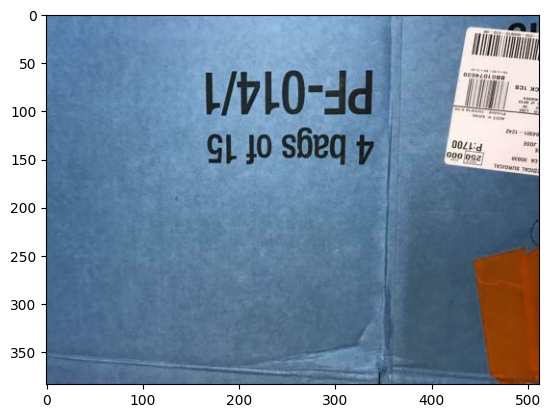

In [330]:
# Plots the image
plt.imshow(random_image)

### 1.3 Load Data

In [331]:
# Specifying the batch size and image size
batch_size = 100
image_width = 256
image_height = 256
num_channels = 3 #RGB

In [332]:
# Splitting the data to a training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 2390 files belonging to 5 classes.
Using 1912 files for training.


In [333]:
# Splitting the data to a training dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 2390 files belonging to 5 classes.
Using 478 files for validation.


In [334]:
classes = train_ds.class_names
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic']

# 2. Data Preprocessing

- This process contains:

    a) Data Standardization

### 2.2 Shuffle Data


In [335]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 2.3 Data Augmentation

In [336]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# 3. Create a Deep Model

In [337]:
# Importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [338]:
# Create the model
model = Sequential()

In [339]:
num_classes = len(classes)
model.add(data_augmentation)
# Create CNN Architecture
model = Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_height, image_width, num_channels)),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), # Adding dropout regularization
    layers.Dense(num_classes, activation='softmax')
])


In [340]:
# Build the model
model.build(input_shape=(batch_size, image_height, image_width, num_channels))

In [341]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [342]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 128, 128, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 64, 64, 64)      

# 4. Train the Model

In [343]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [344]:
hist = model.fit(train_ds, epochs=10, validation_data=validation_ds, batch_size= 32, callbacks=[tensorboard_callback])

Epoch 1/10


20/20 [==============================] - 67s 3s/step - loss: 1.6542 - accuracy: 0.2359 - val_loss: 1.5305 - val_accuracy: 0.2615
Epoch 2/10
20/20 [==============================] - 74s 4s/step - loss: 1.4169 - accuracy: 0.3672 - val_loss: 1.2407 - val_accuracy: 0.5439
Epoch 3/10
20/20 [==============================] - 47s 2s/step - loss: 1.2965 - accuracy: 0.4655 - val_loss: 1.2009 - val_accuracy: 0.5042
Epoch 4/10
20/20 [==============================] - 46s 2s/step - loss: 1.2313 - accuracy: 0.4958 - val_loss: 1.1746 - val_accuracy: 0.5084
Epoch 5/10
20/20 [==============================] - 44s 2s/step - loss: 1.1468 - accuracy: 0.5387 - val_loss: 1.1213 - val_accuracy: 0.5586
Epoch 6/10
20/20 [==============================] - 44s 2s/step - loss: 1.0534 - accuracy: 0.5894 - val_loss: 1.0222 - val_accuracy: 0.6109
Epoch 7/10
20/20 [==============================] - 44s 2s/step - loss: 0.9899 - accuracy: 0.6161 - val_loss: 0.9864 - val_accuracy: 0.6339
Epoch 8/10
20/20 [=============

## 4.1 Visualize the Training Results

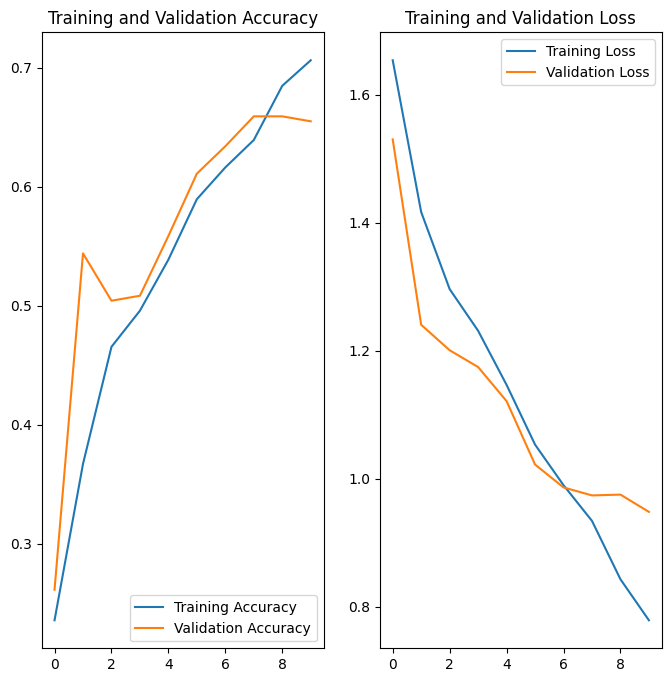

In [345]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5. Model Prediction

In [354]:
glass_path = 'Glass_image2.jpg'

img = tf.keras.utils.load_img(
    glass_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 99ms/step
This image most likely belongs to plastic with a 35.79 percent confidence.
